In [1]:
import ete3 as et # phylogenetics library that provides tree data structure with nice methods for inspection and manipulation
import json # necessary to read in exported nextstrain JSON file

# Load and parse the tree

In [2]:
def make_node(data_dict):
    '''
    data_dict: portion of the nextstrain tree JSON representing either an internal node or leaf
    returns: ete3 TreeNode object with all attributes and relationships populated from the nextstrain JSON
    '''
    node = et.TreeNode()
    node.name = data_dict['name'] # copy name
    node.dist = 0.    # initialize for the root node
    
    def add_features(attrs, node):
        '''
        attrs: dictionary of either `branch_attrs` or `node_attrs` from the nextstrain json
        node: node to attach these to
        side effect: modifies node in place to attach these attributes as `node.features` per ETE3 convention.
                     these can later be referenced via `getattr(node, attribute_name) => value`
        '''
        attrs = { 
            k: v['value'] if # deal with nextstrain json format quirk with occasional nested dictionaries for single-value attributes
                isinstance(v, dict) and 'value' in v
                else v
                for k,v in attrs.items()
                }
        node.add_features(**attrs)
        
    if 'branch_attrs' in data_dict:
        add_features(data_dict['branch_attrs'], node)        
        
    if 'node_attrs' in data_dict:
        cumulative_div = data_dict['node_attrs'].pop('div') # pop out the divergence value to store as `node.dist`, rather than as a metadata feature
        add_features(data_dict['node_attrs'], node)

    
    if 'children' in data_dict and len(data_dict['children']) > 0: # recursively visit each of the children of the node to build out the full tree structure with the right parental relationships
        for c in data_dict['children']:
            if 'node_attrs' in c and 'div' in c['node_attrs']:
                d = c['node_attrs']['div']
            else:
                d = 0.
            node.add_child(make_node(c), 
                           dist = d - cumulative_div) # nextstrain records each node/leaf's *total distance* from the root, not the incremental distance from its parent
    return node
        
def make_tree(json_file):
    '''
    json_file: filehandle to read or pre-parsed JSON file as a dictionary
    returns: ete3.Tree object. NB that ete3.Tree and ete3.TreeNode objects are synonymous; see their docs for more
    '''
    if type(json_file) == str:
        json_dict = json.load(open(json_file, 'r'))
    else:
        assert(type(json_file)==dict)
        json_dict = json_file
        
    tree = make_node(json_dict['tree'])
    return tree

In [3]:
tree_file = '/Users/sbell/auspice/examples/minimal_v2.json'
tree = make_tree(tree_file)
tree.ladderize() # sort / rotate nodes for a tidy looking tree
tree.describe() # basic facts to check we did it right

Number of leaf nodes:	31
Total number of nodes:	56
Rooted:	Yes
Most distant node:	USA/2016/FLUR022
Max. distance:	0.006146


## Bonus / advanced section: plotting trees with matplotlib
    
This implementation uses matplotlib's basic library, lightly adapted from @evogytis's approach in BALTIC. 

You may also want to check out the gallery of ETE toolkit examples of how to plot trees using its built in functions. 
http://etetoolkit.org/docs/latest/tutorial/tutorial_drawing.html

In [4]:
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

In [5]:
'''
CREDITS: This function is lightly adapted from the baltic package created by Gytis Dudas.
https://github.com/blab/baltic/blob/master/baltic.py#L268
'''

def assign_x_y_coordinates(tree, verbose=False):
    """ Find x and y coordinates of each branch. """
    tree.ladderize() ## rotate nodes for a tidier tree
    root = tree.get_tree_root()
    order = [k for k in tree.traverse('postorder')]
    name_order=[getattr(k, 'name') for k in order]
    skips = [1 for k in order]

    for k in order: ## reset coordinates for all objects
        k.del_feature('x')
        k.del_feature('y')
        
    storePlotted=0
    drawn={} ## drawn keeps track of what's been drawn
    
    def get_height(k, root = root):
        return k.get_distance(root)
    
    while len(drawn)!=len(order): # keep drawing the tree until everything is drawn
        if verbose==True:
            print('Drawing iteration %d'%(len(drawn)))
        for k in filter(lambda w:w.name not in drawn,order): ## iterate through objects that have not been drawn
            if k.is_leaf(): ## if leaf - get position of leaf, draw branch connecting tip to parent node
                if verbose==True:
                    print('Setting leaf %s y coordinate to'%(k.name))
                x=get_height(k) ## x position is distance from root
                y_idx=name_order.index(k.name) ## y position of leaf is given by the order in which tips were visited during the traversal
                y=sum(skips[y_idx:]) ## sum across skips to find y position
                if verbose==True:
                    print('%s'%(y))
                k.add_feature('x', x) ## set x and y coordinates
                k.add_feature('y', y)
                drawn[k.name]=None ## remember that this objects has been drawn
                if hasattr(k.up,'yRange')==False: ## if parent doesn't have a maximum extent of its children's y coordinates
                    k.up.add_feature('yRange',[k.y,k.y]) ## assign it

            elif not k.is_root(): ## if parent is non-root node and y positions of all its children are known
                if len([q.y for q in k.children if hasattr(q, 'y')])==len(k.children):
                    if verbose==True:
                        print('Setting node %s coordinates'%(k.name))
                    x=get_height(k) ## x position is height
                    children_y_coords=[q.y for q in k.children]# if hasattr(q, y)] ## get all existing y coordinates of the node
                    y=sum(children_y_coords)/float(len(children_y_coords)) ## internal branch is in the middle of the vertical bar
                    k.add_feature('x', x)
                    k.add_feature('y', y)
                    drawn[k.name]=None ## remember that this objects has been drawn
                    minYrange=min([min(child.yRange) if not child.is_leaf() else child.y for child in k.children]) ## get lowest y coordinate across children
                    maxYrange=max([max(child.yRange) if not child.is_leaf() else child.y for child in k.children]) ## get highest y coordinate across children
                    k.add_feature('yRange', [minYrange,maxYrange]) ## assign the maximum extent of children's y coordinates

        if len(drawn) <= storePlotted:
            break
        storePlotted=len(drawn)

In [6]:
def plot_tree(tree, colorby = None, y_stretch = 1.0, tip_size = 20, 
              branchWidth=2, ax=None, palette = plt.cm.Pastel2):    
    
    '''
    tree = ete3 TreeNode object
    colorby = categorical metadata feature to color the leaves by
    y_stretch = factor by which to stretch out the figure vertically (useful for dense trees)
    tip_size = size of the circles for each leaf
    branchWidth = width of the line for each branch
    ax = matplotlib ax object to plot on, useful for positioning in subplots
    palette = matplotlib color palette to use `colorby
    '''
    
    if not ax: ## create an axis if needed
        fig, ax = plt.subplots()
    
    if colorby: ## create a colormap for categorical values
        vals = sorted(list(
                set([getattr(l, colorby, None) for l in tree.iter_leaves()])))
        colors = np.linspace(0,1,len(vals))
        cmap = {val : palette(color) for val, color in zip(vals, colors)}
#         plt.legend(handles = colors, labels = vals) 
    
    for k in tree.traverse(): ## iterate over each node and leaf in the tree
        x = getattr(k, 'x', 0.0) # define coordinates; fill in 0.0 for any missing coordinates
        xp = getattr(k.up, 'x', 0.0)
        y = getattr(k, 'y', 0.0)*y_stretch

        # plot leaves
        if k.is_leaf(): 
            if colorby == None or colorby not in k.features:
                c = 'darkgray'  # plot missing colorby values in gray
            else:
                c = cmap[getattr(k, colorby)] # leaf color
            
#             plt.text(x*1.05, y, k.name, fontsize=9, va='center') # leaf labels
            plt.scatter(x,y,s=tip_size,facecolor=c,edgecolor='none',zorder=11) ## plot circle for every leaf
            plt.scatter(x,y,s=1.8*tip_size,facecolor='black',edgecolor='none',zorder=10) ## plot black outline
                        
        # plot internal nodes
        else: 
            plt.plot([x,x],[k.children[-1].y*y_stretch,k.children[0].y*y_stretch],lw=branchWidth,color='darkgray',ls='-',zorder=9) # vertical lines
                    
        # plot branches
        plt.plot([xp,x],[y,y],lw=branchWidth,color='darkgray',ls='-',zorder=9)

    for side in ['top', 'right', 'bottom', 'left']:
        ax.spines[side].set_visible(False)
    plt.yticks(size=0) ## turn off y axis

    plt.show()

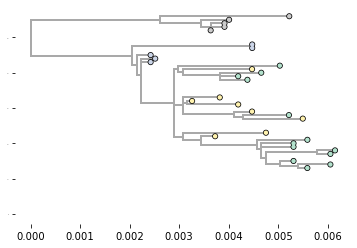

In [7]:
assign_x_y_coordinates(tree)
plot_tree(tree, colorby='region')